In [1]:
import os
print("os")
import glob
print("glob")
import torch
print("torch")
from torch import nn
print("nn")
import torch.nn.functional as F
print("F")
import torch.optim as optim
print("optim")
from torch.utils.data import Dataset
print("Dataset")
from torch.utils.data import DataLoader
print("DataLoader")
from ast import literal_eval
print("literal_eval")
import pandas as pd
print("pd")
import numpy as np
print("np")
import matplotlib.pyplot as plt
print("plt")
import itertools
print("itertools")
import random
print("random")
from torch.autograd import Variable
print("Variable")
import gc
print("gc")


os
glob
torch
nn
F
optim
Dataset
DataLoader
literal_eval
pd
np
plt
itertools
random
Variable
gc


In [2]:
torch.cuda.set_device(0) 

In [20]:
class BatchDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Only select the first 2000 rows for now
        self.labels = pd.read_csv(csv_file).iloc[:2000]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        X = torch.load(feature_path)
        y = torch.FloatTensor([float(label) for label in literal_eval(self.labels.iloc[idx, 1])])
        if self.transform:
            embedding = self.transform(embedding)
        #return X, y, self.labels.iloc[idx,0]
        return X, y
    
dataset = BatchDataset(csv_file='/home/vera/projects/masters_project/data/rmsd_dataset.csv',
                                    root_dir='/home/vera/projects/masters_project/data/s-pred_features/')

print(dataset[0][0].shape, dataset[0][1].shape)

torch.Size([1, 85, 1056]) torch.Size([85])


In [21]:
BATCH_SIZE = 32

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def train_val_test_split(dataset, batch_size=1, val_split=0.1, test_split=0.1, shuffle=True):
    """
    Split a dataset into train, validation and test subsets.
    
    Args:
        dataset (Dataset): Dataset to be split
        batch_size (int): Batch size
        val_split (float): Proportion of validation images
        test_split (float): Proportion of test images
        shuffle (bool): Whether to shuffle the dataset before splitting
    Returns:
        train_sampler, val_sampler, test_sampler (SubsetRandomSampler): Samplers for each subset
    """
    # Obtain split sizes
    test_size = int(len(dataset) * test_split)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size - test_size

    # Split dataset into train, validation and test
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Sort sequences by length
    train_dataset = sorted(train_dataset, key=lambda x: x[0].shape[1], reverse=True)

    # Shuffle every n*batch_size sequences to avoid having sequences of the same length in the same batch
    shuffle_length = batch_size * 2
    if shuffle:
        for i in range(0, len(train_dataset)-shuffle_length, shuffle_length):
            shuffle_batch = train_dataset[i:i+shuffle_length]
            random.shuffle(shuffle_batch)
            train_dataset[i:i+shuffle_length] = shuffle_batch

    print("Shuffled dataset")
    # For every n:th sequence, where n is the batch size, pad the sequence to be as long as the longest sequence in the batch
    # This is done to avoid having to pad every sequence to the same length, which would result in a lot of unnecessary padding
    batches = []
    for i in range(0, len(train_dataset), batch_size):
        batch = train_dataset[i:i+batch_size]
        max_len = batch[0][0].shape[1]
        batch_list = []
        for item in batch:
            X = F.pad(item[0], (0, 0, 0, max_len-item[0].shape[1]), "constant", 0)
            y = F.pad(item[1], (0, max_len-item[1].shape[0]), "constant", 0)
            batch_list.append((X, y))
        batches.append(batch_list)
        gc.collect()

    # Shuffle the batches 
    random.shuffle(batches)

    # Put the batches back together
    train_dataset = [item for sublist in batches for item in sublist]
    batches = []

    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = train_val_test_split(dataset, batch_size=BATCH_SIZE)
train_dataset = train_dataset
val_dataset = val_dataset
test_dataset = test_dataset

print(type(train_dataset))
print(type(train_dataset[0]))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)
print(train_dataset[1][0].shape, train_dataset[1][1].shape)
print(train_dataset[2][0].shape, train_dataset[2][1].shape)
print(train_dataset[3][0].shape, train_dataset[3][1].shape)


gc.collect()
torch.cuda.empty_cache()

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Test the dataloaders
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

Shuffled dataset
<class 'list'>
<class 'tuple'>
torch.Size([1, 231, 1056]) torch.Size([231])
torch.Size([1, 231, 1056]) torch.Size([231])
torch.Size([1, 231, 1056]) torch.Size([231])
torch.Size([1, 231, 1056]) torch.Size([231])
torch.Size([32, 1, 231, 1056])
torch.Size([32, 231])


In [22]:
print(train_dataset[0][1])

tensor([0.0000, 0.0220, 0.0220, 0.0220, 0.0220, 0.0220, 0.0220, 0.0210, 0.0190,
        0.0210, 0.0240, 0.0270, 0.0270, 0.0260, 0.0270, 0.0220, 0.0220, 0.0230,
        0.0240, 0.0210, 0.0120, 0.0170, 0.0230, 0.0220, 0.0260, 0.0270, 0.0300,
        0.0300, 0.0300, 0.0290, 0.0270, 0.0230, 0.0160, 0.0070, 0.0090, 0.0070,
        0.0090, 0.0190, 0.0220, 0.0230, 0.0200, 0.0190, 0.0210, 0.0230, 0.0210,
        0.0200, 0.0200, 0.0090, 0.0150, 0.0230, 0.0230, 0.0240, 0.0240, 0.0300,
        0.0290, 0.0270, 0.0280, 0.0270, 0.0140, 0.0180, 0.0210, 0.0220, 0.0190,
        0.0190, 0.0190, 0.0200, 0.0200, 0.0180, 0.0230, 0.0340, 0.0650, 0.0670,
        0.0680, 0.0670, 0.0660, 0.0670, 0.0630, 0.0570, 0.0390, 0.0320, 0.0150,
        0.0120, 0.0110, 0.0110, 0.0110, 0.0120, 0.0100, 0.0080, 0.0070, 0.0060,
        0.0080, 0.0100, 0.0080, 0.0060, 0.0070, 0.0110, 0.0110, 0.0110, 0.0210,
        0.0270, 0.0270, 0.0270, 0.0280, 0.0270, 0.0250, 0.0270, 0.0250, 0.0220,
        0.0130, 0.0100, 0.0080, 0.0080, 

In [23]:
# Split dataset into train, validation and test sets
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Test if the dataset is split correctly
print(len(train_dataset), len(valid_dataset), len(test_dataset))

# Create the dataloaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Test if the dataloaders are working correctly
# for i, (X, y) in enumerate(train_loader):
#     print(X.shape, y.shape)
#     break

1600 200 200


In [28]:
# Create the LSTM model
class lstm_net(nn.Module):

    def __init__(self, input_feature_size=768, hidden_node=256, dropout=0.25, class_num=8):
        super(lstm_net, self).__init__()

        self.linear_proj = nn.Sequential(
            nn.Linear(input_feature_size, input_feature_size // 2),
            nn.InstanceNorm1d(input_feature_size // 2),
            nn.ReLU(),
            nn.Linear(input_feature_size // 2, input_feature_size // 4),
            nn.InstanceNorm1d(input_feature_size // 4),
            nn.ReLU(),
            nn.Linear(input_feature_size // 4, input_feature_size // 4),
        )

        lstm_input_feature_size = input_feature_size // 4 + 144*2

        self.lstm = nn.LSTM(
            input_size=lstm_input_feature_size,
            hidden_size=hidden_node,
            num_layers=2,
            bidirectional=True,
            dropout=dropout,
            batch_first=True,
        )

        self.to_property = nn.Sequential(
            nn.Linear(hidden_node * 2, hidden_node * 2),
            nn.InstanceNorm1d(hidden_node * 2),
            nn.ReLU(),
            nn.Linear(hidden_node * 2, class_num),
        )

    def forward(self, msa_query_embeddings, msa_attention_features):
        msa_query_embeddings = self.linear_proj(msa_query_embeddings)

        lstm_input = torch.cat([msa_query_embeddings, msa_attention_features], dim=2)
        lstm_input = lstm_input.permute((1, 0, 2))

        lstm_output, lstm_hidden = self.lstm(lstm_input)
        lstm_output = lstm_output.permute((1, 0, 2))
        
        label_output = self.to_property(lstm_output)
        #print(lstm_output)
        #print(label_output)

        return label_output

In [29]:
EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0
#WEIGHT_DECAY = 0.0001
HIDDEN_NODE = 256
DROPOUT = 0

CLASS_NUM = 1
NUM_ACCUMULATION_STEPS = 2

RMSD_THRESHOLD = 0.5

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


model = lstm_net(input_feature_size=768, hidden_node=HIDDEN_NODE, dropout=DROPOUT, class_num=CLASS_NUM)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_loss_list = []
valid_loss_list = []

model.train()

for epoch in range(1, EPOCHS+1):
    model.zero_grad()
    train_loss = 0
    valid_loss = 0

    for i, (X, y) in enumerate(train_loader):
        features = X[:,0,:,:768].to(device)
        maps = X[:,0,:,768:].to(device)
        labels = (y >= RMSD_THRESHOLD).float().to(device)
        optimizer.zero_grad()

        output = model(msa_query_embeddings=features, msa_attention_features=maps)
        loss = criterion(output[:,:,0], labels)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss_list.append(train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            features = X[:,0,:,:768].to(device)
            maps = X[:,0,:,768:].to(device)
            labels = (y >= RMSD_THRESHOLD).float().to(device)
            optimizer.zero_grad()

            output = model(msa_query_embeddings=features, msa_attention_features=maps)
            loss = criterion(output[:,:,0], labels)
            valid_loss += loss.item()

        valid_loss_list.append(valid_loss / len(val_loader))

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss_list[-1], valid_loss_list[-1]))
    
    model.train()
        


/home/vera/miniconda3/envs/SE3-nvidia/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch: 1 	Training Loss: 0.693286 	Validation Loss: 0.693147
Epoch: 2 	Training Loss: 0.693147 	Validation Loss: 0.693147
Epoch: 3 	Training Loss: 0.693147 	Validation Loss: 0.693147
Epoch: 4 	Training Loss: 0.693147 	Validation Loss: 0.693147
Epoch: 5 	Training Loss: 0.693147 	Validation Loss: 0.693147


KeyboardInterrupt: 

In [9]:
for i, (X, y) in enumerate(train_loader):
    print(X.shape)
    print(y.shape)
    print(y)
    print((y >= RMSD_THRESHOLD).long())
    break

torch.Size([1, 1, 88, 1056])
torch.Size([1, 88])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0200e-01, 1.0200e-01,
         1.0200e-01, 1.0200e-01, 1.0200e-01, 1.0200e-01, 7.9000e-02, 8.0000e-02,
         7.5000e-02, 7.1000e-02, 6.4000e-02, 3.3000e-02, 1.5000e-02, 1.3000e-02,
         2.0000e-02, 2.3000e-02, 2.4000e-02, 2.4000e-02, 2.0000e-02, 1.6000e-02,
         1.7000e-02, 1.9000e-02, 2.5000e-02, 3.0000e-02, 3.0000e-02, 2.8000e-02,
         2.6000e-02, 3.0000e-02, 4.2000e-02, 6.1000e-02, 4.5000e-02, 4.1000e-02,
         3.9000e-02, 4.3000e-02, 3.0000e-02, 1.9000e-02, 1.6000e-02, 1.5000e-02,
         1.4000e-02, 1.3000e-02, 1.6000e-02, 1.7000e-02, 2.1000e-02, 2.3000e-02,
         8.1000e-02, 5.9400e-01, 3.7460e+00, 5.4930e+00, 7.0810e+00, 9.5030e+00,
         1.0983e+01, 1.1920e+01, 1.0587e+01, 8.6580e+00, 8.1910e+00, 7.2000e+00,
         3.2200e+00, 1.6400e-01, 8.6000e-02, 1.0200e-01, 1.0400e-01, 5.8400e-01,
         5.8400e-01, 5.8400e-01, 5.8400e-01, 5.8500e-01, 5.8

torch.Size([1, 365, 1])
(365,)
torch.Size([1, 317, 1])
(317,)
torch.Size([1, 253, 1])
(253,)
torch.Size([1, 222, 1])
(222,)
torch.Size([1, 299, 1])
(299,)


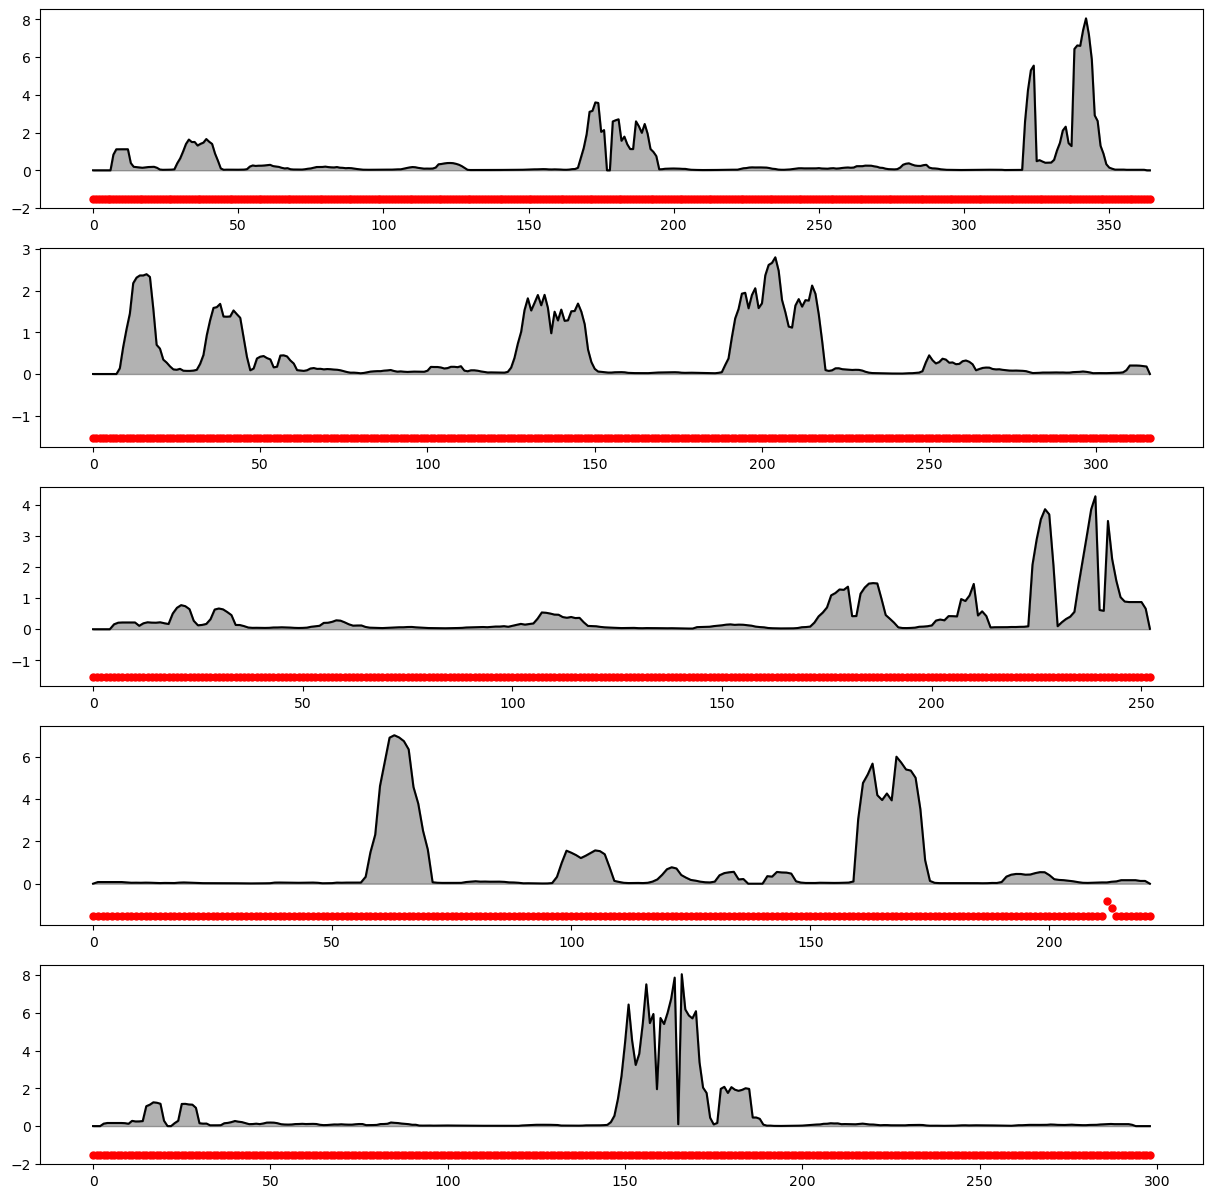

In [15]:
# Viusalize the predicted labels and the true labels for five random proteins
model.eval()

fig = plt.figure(figsize=(15, 15))

for i in range(5):
    # Add subplot vertically
    ax = fig.add_subplot(5, 1, i+1)

    # Test for a single protein
    X, y  = test_dataset[random.randint(0, len(test_dataset))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        features = X[:,:,:768].to(device)
        maps = X[:,:,768:].to(device)
        labels = y.float().to(device)
        optimizer.zero_grad()

        output = model(msa_query_embeddings=features, msa_attention_features=maps)
        print(output.shape)
        predicted_labels = output[0,:,0].cpu().numpy()
        print(predicted_labels.shape)

    # Plot the actual labels as black
    ax.plot(labels.cpu().numpy(), color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None', markersize=5)
    # Fill under the actual labels
    ax.fill_between(range(len(labels)), labels.cpu().numpy(), color='black', alpha=0.3)


plt.show()

In [29]:
# Create the LSTM model
class lstm_idr_net(nn.Module):

    def __init__(self, input_feature_size=768, hidden_node=256, dropout=0.25, class_num=8):
        super(lstm_idr_net, self).__init__()

        self.linear_proj = nn.Sequential(
            nn.Linear(input_feature_size, input_feature_size // 2),
            nn.InstanceNorm1d(input_feature_size // 2),
            nn.ReLU(),
            nn.Linear(input_feature_size // 2, input_feature_size // 4),
            nn.InstanceNorm1d(input_feature_size // 4),
            nn.ReLU(),
            nn.Linear(input_feature_size // 4, input_feature_size // 4),
        )

        lstm_input_feature_size = input_feature_size // 4 + 144*2

        self.lstm = nn.LSTM(
            input_size=lstm_input_feature_size,
            hidden_size=hidden_node,
            num_layers=2,
            bidirectional=True,
            dropout=dropout,
        )

        self.to_property = nn.Sequential(
            nn.Linear(hidden_node * 2, hidden_node * 2),
            nn.InstanceNorm1d(hidden_node * 2),
            nn.ReLU(),
            nn.Linear(hidden_node * 2, class_num),
        )

    def forward(self, msa_query_embeddings, msa_attention_features):
        msa_query_embeddings = self.linear_proj(msa_query_embeddings)

        lstm_input = torch.cat([msa_query_embeddings, msa_attention_features], dim=2)
        
        lstm_input = lstm_input.permute((1, 0, 2))
        lstm_output, lstm_hidden = self.lstm(lstm_input)
        lstm_output = lstm_output.permute((1, 0, 2))
        label_output = self.to_property(lstm_output)
        #print(lstm_output)
        #print(label_output)

        return label_output

In [23]:
# Create the LSTM model
class lstm_regression_net(nn.Module):

    def __init__(self, input_feature_size=768, hidden_node=256, dropout=0.25, class_num=8):
        super(lstm_regression_net, self).__init__()

        self.linear_proj = nn.Sequential(
            nn.Linear(input_feature_size, input_feature_size // 2),
            nn.InstanceNorm1d(input_feature_size // 2),
            nn.ReLU(),
            nn.Linear(input_feature_size // 2, input_feature_size // 4),
            nn.InstanceNorm1d(input_feature_size // 4),
            nn.ReLU(),
            nn.Linear(input_feature_size // 4, input_feature_size // 4),
        )

        lstm_input_feature_size = input_feature_size // 4 + 144*2

        self.lstm = nn.LSTM(
            input_size=lstm_input_feature_size,
            hidden_size=hidden_node,
            num_layers=2,
            bidirectional=True,
            dropout=dropout,
        )

        self.to_property = nn.Sequential(
            nn.Linear(hidden_node * 2, hidden_node * 2),
            nn.InstanceNorm1d(hidden_node * 2),
            nn.ReLU(),
            nn.Linear(hidden_node * 2, class_num),
        )

    def forward(self, msa_query_embeddings, msa_attention_features):
        msa_query_embeddings = self.linear_proj(msa_query_embeddings)

        lstm_input = torch.cat([msa_query_embeddings, msa_attention_features], dim=2)
        
        lstm_input = lstm_input.permute((1, 0, 2))
        lstm_output, lstm_hidden = self.lstm(lstm_input)
        lstm_output = lstm_output.permute((1, 0, 2))
        label_output = self.to_property(lstm_output)
        #print(lstm_output)
        #print(label_output)

        return label_output

In [35]:
EPOCHS = 50
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0
WEIGHT_DECAY = 0.00001
HIDDEN_NODE = 256
DROPOUT = 0

CLASS_NUM = 1
NUM_ACCUMULATION_STEPS = 2

RMSD_THRESHOLD = 0.5

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


model = lstm_regression_net(input_feature_size=768, hidden_node=HIDDEN_NODE, dropout=DROPOUT, class_num=CLASS_NUM)

#model = lstm_regression_net(input_feature_size=768, hidden_node=256, dropout=0, class_num=1)


model = model.to(device)
location = '../data/s_pred_idr_weights.pth'
if device.type == 'cpu':
    ch = torch.load(location, map_location=torch.device('cpu'))
else:
    ch = torch.load(location)
model.load_state_dict(ch['conv_model'])



device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_loss_list = []
valid_loss_list = []

model.train()

for epoch in range(1, EPOCHS+1):
    model.zero_grad()
    train_loss = 0
    valid_loss = 0

    for i, (X, y) in enumerate(train_loader):
        features = X[:,0,:,:768].to(device)
        maps = X[:,0,:,768:].to(device)
        labels = y.float().to(device)
        optimizer.zero_grad()

        output_property = model(msa_query_embeddings=features, msa_attention_features=maps)
        if i == 0 and epoch == 1:
            print(output_property.shape)
            print(labels.shape)
        loss = criterion(output_property[:,:,0], labels)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss_list.append(train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            features = X[:,0,:,:768].to(device)
            maps = X[:,0,:,768:].to(device)
            labels = y.float().to(device)
            optimizer.zero_grad()
            output = model(msa_query_embeddings=features, msa_attention_features=maps)
            loss = criterion(output[:,:,0], labels)
            valid_loss += loss.item()

        valid_loss_list.append(valid_loss / len(val_loader))

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss_list[-1], valid_loss_list[-1]))
    
    model.train()
        


/home/vera/miniconda3/envs/SE3-nvidia/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


torch.Size([32, 246, 1])
torch.Size([32, 246])
Epoch: 1 	Training Loss: 18.596552 	Validation Loss: 13.395795
Epoch: 2 	Training Loss: 18.545701 	Validation Loss: 13.470227
Epoch: 3 	Training Loss: 18.536679 	Validation Loss: 13.388454
Epoch: 4 	Training Loss: 18.537880 	Validation Loss: 13.374705
Epoch: 5 	Training Loss: 18.542874 	Validation Loss: 13.255304
Epoch: 6 	Training Loss: 18.534473 	Validation Loss: 13.295826
Epoch: 7 	Training Loss: 18.525760 	Validation Loss: 13.173653
Epoch: 8 	Training Loss: 18.516321 	Validation Loss: 13.531841
Epoch: 9 	Training Loss: 18.536787 	Validation Loss: 13.020024
Epoch: 10 	Training Loss: 18.519150 	Validation Loss: 12.981826
Epoch: 11 	Training Loss: 18.502453 	Validation Loss: 13.043259
Epoch: 12 	Training Loss: 18.492994 	Validation Loss: 13.051049
Epoch: 13 	Training Loss: 18.486723 	Validation Loss: 13.047667
Epoch: 14 	Training Loss: 18.481273 	Validation Loss: 13.062616
Epoch: 15 	Training Loss: 18.484109 	Validation Loss: 13.072995
Ep

In [58]:
torch.cuda.empty_cache()

In [16]:
print(test_dataset[0][0].shape)

torch.Size([1, 117, 1056])


In [89]:
conv_model = lstm_idr_net(input_feature_size=768, hidden_node=256, dropout=0.25, class_num=1)
conv_model = conv_model.to(device)
conv_model_path = '../data/s_pred_asa_weights.pth'

if device.type == 'cpu':
    ch = torch.load(conv_model_path, map_location=torch.device('cpu'))
else:
    ch = torch.load(conv_model_path)

conv_model.load_state_dict(ch['conv_model'])
conv_model.to(device)
conv_model.eval()

lstm_idr_net(
  (linear_proj): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): InstanceNorm1d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Linear(in_features=384, out_features=192, bias=True)
    (4): InstanceNorm1d(192, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Linear(in_features=192, out_features=192, bias=True)
  )
  (lstm): LSTM(480, 256, num_layers=2, dropout=0.25, bidirectional=True)
  (to_property): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

torch.Size([1, 184, 1])
(184,)
torch.Size([1, 170, 1])
(170,)
torch.Size([1, 206, 1])
(206,)
torch.Size([1, 180, 1])
(180,)
torch.Size([1, 212, 1])
(212,)


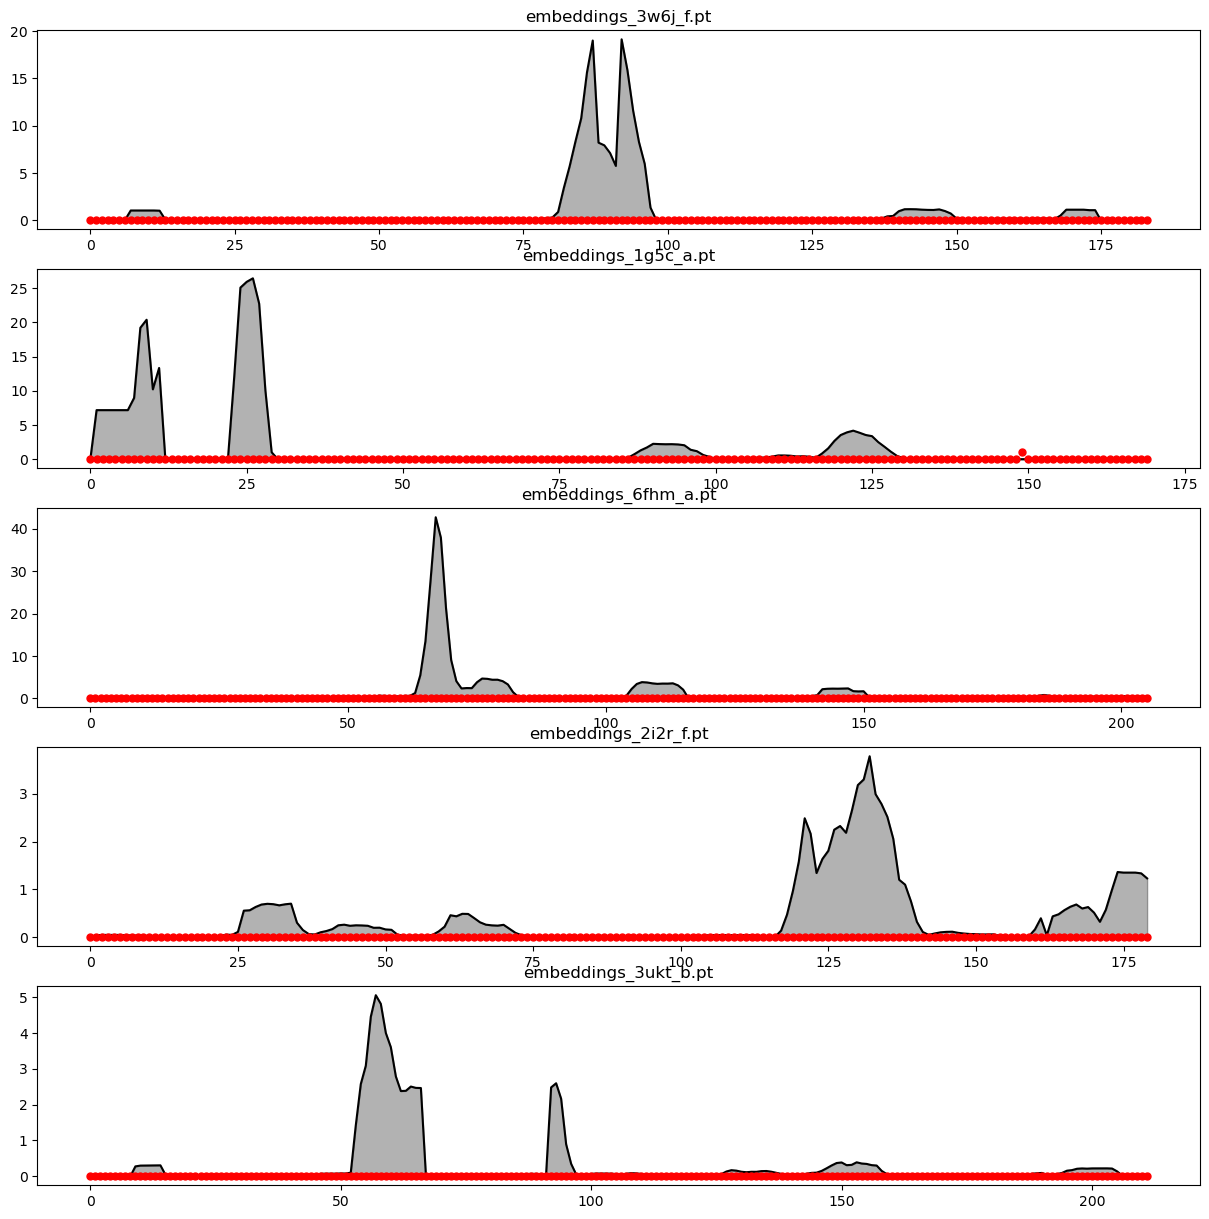

In [108]:
# Viusalize the predicted labels and the true labels for five random proteins
conv_model.eval()

fig = plt.figure(figsize=(15, 15))

for i in range(5):
    # Add subplot vertically
    ax = fig.add_subplot(5, 1, i+1)

    # Test for a single protein
    X, y, name  = test_dataset[random.randint(0, len(test_dataset))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        features = X[:,:,:768].to(device)
        maps = X[:,:,768:].to(device)
        labels = y.float().to(device)

        output = conv_model(msa_query_embeddings=features, msa_attention_features=maps)
        #output = output.squeeze(dim=2)
        output = F.sigmoid(output)
        print(output.shape)
        predicted_labels = output.data.cpu().numpy().squeeze()
        print(predicted_labels.shape)
        idr = predicted_labels >= 0.5
        not_idr = predicted_labels < 0.5

    # Plot the actual labels as black
    ax.plot(labels.cpu().numpy(), color='black')
    ax.plot((predicted_labels > 0.5), color='red', marker='o', linestyle='None', markersize=5)
    # Fill under the actual labels
    ax.fill_between(range(len(labels)), labels.cpu().numpy(), color='black', alpha=0.3)
    ax.set_title(name)

plt.show()
    